In [1]:
import sys
import pystan
import stan_utility

import arviz as az
import numpy as np
import scipy.stats as stats

import pandas as pd

## Gamma distribution
Model for gamma distribution created in .stan file. For gamma distribution we provide alpha and beta parameters. Alpha and beta parameters are accordingly equal 2 and 1. Model sampling iteration parameter is equal 1000. 

In [2]:
#zad.1
with open('gamma.stan', 'r') as file:
    print(file.read())

/*
gamma distribution
*/

data {
    real alpha;
    real beta;
}

generated quantities {
    real y = gamma_rng (alpha, beta);
}


In [3]:
model=stan_utility.compile_model('gamma.stan')

Using cached StanModel


In [6]:
R=1000
sim_data=dict(alpha=2, beta=1)
sim_ppc=model.sampling(data=sim_data,algorithm="Fixed_param", iter=R, warmup=0, chains=1)

In [7]:
y = sim_ppc.extract()['y']
#print(y)

## Histogram for gamma distribution
Below gamma histogram along with probability density function. 

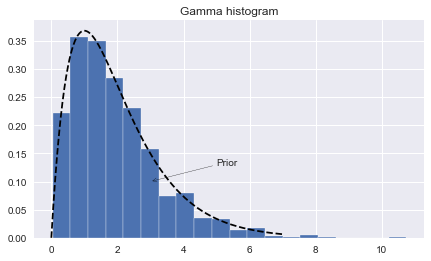

In [8]:
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn')
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
ax1=axes
ax1.hist(y,bins=20, density=True, edgecolor='white')
x=np.linspace(0,7,500)
alpha = 2
beta = 1
ax1.plot(x,stats.gamma.pdf(x,a=alpha,scale=1/beta),color='black',linestyle='--')
ax1.set_title(r'Gamma histogram')
ax1.annotate('Prior',xy=(3,0.1),xytext=(5,0.13),arrowprops={'arrowstyle':'->'})
plt.show()

## Inverse gamma distribution
Model created in .stan file. Similarly to just gamma distribution, here parameters are also only alpha and beta

In [9]:
with open('inv_gamma.stan', 'r') as file:
    print(file.read())

/*
inv_gamma distribution
*/

data {
    real alpha;
    real beta;
}

generated quantities {
    real y = inv_gamma_rng (alpha, beta);
}


In [10]:
model=stan_utility.compile_model('inv_gamma.stan')

Using cached StanModel


In [53]:
R=1000
sim_data=dict(alpha=5, beta=3)
sim_ppc=model.sampling(data=sim_data,algorithm="Fixed_param", iter=R, warmup=0, chains=1, refresh=R, seed=29042020)

In [54]:
y = sim_ppc.extract()['y']
#print(y)

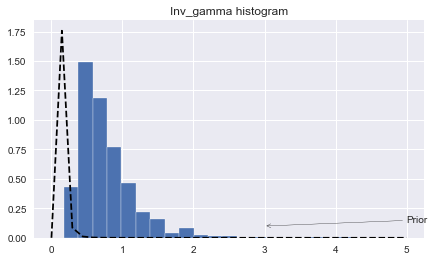

In [55]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
ax1=axes
ax1.hist(y,bins=20, density=True, edgecolor='white')
x=np.linspace(0,5,35)
alpha = 5
beta = 3
ax1.plot(x,stats.invgamma.pdf(x,a=alpha,scale=1/beta),color='black',linestyle='--')
ax1.set_title(r'Inv_gamma histogram')
ax1.annotate('Prior',xy=(3,0.1),xytext=(5,0.13),arrowprops={'arrowstyle':'->'})
plt.show()

## parameters for Gamma for which 98% probability is for values between 5 and 10
Here we will use the cumulative gamma distribution function and algebra solver to calculate appropriate alpha and beta values. 

In [67]:
with open('gamma_new.stan', 'r') as file:
    print(file.read())

functions {
  vector gamma_fun(vector y, vector theta, real[] x_r, int[] x_i) {
    vector[3] deltas;
    
    deltas[1] = gamma_cdf(theta[1], y[1], y[2]) - y[3];
    deltas[2] = gamma_cdf(theta[2], y[1], y[2]) - (y[3] + 0.98);
    deltas[3] = y[1]/y[2] - 8;
    
    return deltas;
  }
}

data {
  vector[2] theta;     
  vector[3] y_guess;
}

transformed data {
  vector[3] y;
  real x_r[0];
  int x_i[0];
  
  y = algebra_solver(gamma_fun, y_guess, theta, x_r, x_i);
}

generated quantities {
    real gamma = gamma_rng(y[1],y[2]);
    real alpha = y[1];
    real beta = y[2];
}


In [68]:
model_ppc=stan_utility.compile_model('gamma_new.stan')

Using cached StanModel


In [69]:
R=1000
theta = [5,10]
y_guess = [6.7, 0.83, 0.09]
sim_data=dict(theta=theta, y_guess=y_guess)
sim=model_ppc.sampling(data=sim_data,
                      algorithm="Fixed_param", 
                      iter=R, 
                      warmup=0, 
                      chains=1,
                      seed=29042020)


In [70]:
params=sim.extract()
gamma=params['gamma']
alpha=params['alpha'][0]
beta=params['beta'][0]
print("alpha value = ", alpha)
print("beta value = ", beta)

alpha value =  75.81520441941879
beta value =  9.476900552427344


## Histogram showing results of taken alpha and beta values
As we can see below most values (98%) is within 5 to 10 range. In this case values that are not in the range are the ones that are bigger than 10.

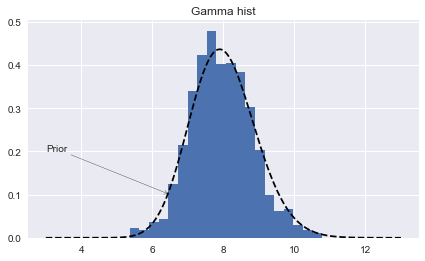

In [71]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
ax1=axes
ax1.hist(gamma,bins=20,density=True)
x=np.linspace(3,13,500)
ax1.plot(x,stats.gamma.pdf(x,a=alpha,scale=1/beta),color='black',linestyle='--')
ax1.set_title(r'Gamma hist')
ax1.annotate('Prior',xy=(6.5,0.1),xytext=(3,0.2),arrowprops={'arrowstyle':'->'})

plt.show()

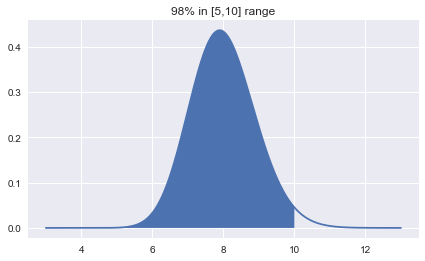

In [512]:
fig, ax2 = plt.subplots(1, 1,figsize=(7, 4))
x2=np.linspace(3,13,1000)
x4=np.linspace(5,10,1000)
ax2.plot(x2,stats.gamma.pdf(x= x2,a= alpha,loc= 0,scale= 1/beta))
ax2.fill_between(x4,stats.gamma.pdf(x= x4,a= alpha,loc= 0,scale= 1/beta),0)
ax2.set_title(r'98% in [5,10] range')
plt.show()

In [516]:
#inv_gamma

In [517]:
#with open('inv_gamma_new.stan', 'r') as file:
#    print(file.read())

In [518]:
#model_ppc=stan_utility.compile_model('inv_gamma_new.stan')

In [520]:
'''R=1000
theta = [5,10]
y_guess = [2, 10, 0.0001]
sim_data=dict(theta=theta, y_guess=y_guess)
sim=model_ppc.sampling(data=sim_data,
                      algorithm="Fixed_param", 
                      iter=R, 
                      warmup=0, 
                      chains=1,
                      seed=29042020)'''

'R=1000\ntheta = [5,10]\ny_guess = [2, 10, 0.0001]\nsim_data=dict(theta=theta, y_guess=y_guess)\nsim=model_ppc.sampling(data=sim_data,\n                      algorithm="Fixed_param", \n                      iter=R, \n                      warmup=0, \n                      chains=1,\n                      seed=29042020)'

## Negative binomial distribution- concentration parametrization
For concentration parametrization we will use alpha and beta parameters for creating histograms. We will compare binomial distribution to poisson one. 

In [82]:
#zad.2
# negative binomial concentration
with open('neg_bin_con.stan', 'r') as file:
    print(file.read())
    

/*
negative binomial distribution concentration
*/

data {
    real alpha;
    real beta;
}

generated quantities {
    real nbin_con = neg_binomial_rng (alpha, beta);
    real poisson_con = poisson_rng(alpha/beta);
}


In [84]:
model_ppc=stan_utility.compile_model('neg_bin_con.stan')

Using cached StanModel


In [99]:
alpha = 5
beta = 1
R=1000
data_sim=dict(alpha=alpha,beta=beta)
sim=model_ppc.sampling(data=data_sim,algorithm="Fixed_param", iter=R, warmup=0, chains=1, refresh=R,
                     seed=29042020)

In [100]:
params_sim=sim.extract()
nbin_con=params_sim['nbin_con']
poisson_con=params_sim['poisson_con']

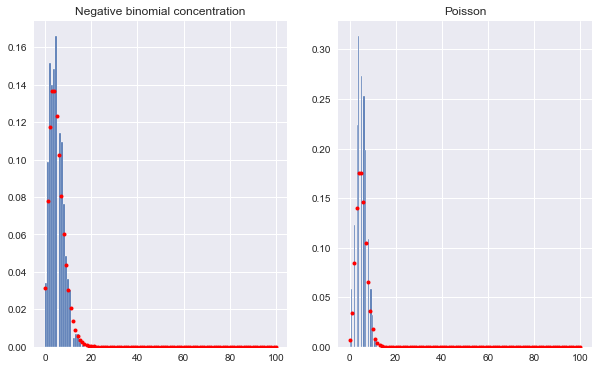

In [104]:
x=np.linspace(0,100,101)
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

ax1=axes[0]
ax1.hist(nbin_con,bins=20, edgecolor='white', density=True)
ax1.plot(x, stats.nbinom.pmf(x, n=alpha, p=(beta/(beta+1))),  'ro', markersize=4)
#ax1.set_yticks([])
ax1.set_title(r'Negative binomial concentration')

ax2=axes[1]
ax2.hist(poisson_con,edgecolor='white',density=True,bins=20)
ax2.plot(x,stats.poisson.pmf(x, alpha/beta), 'ro', markersize=4)
ax2.set_title('Poisson')

plt.show()

## Negative binomial distribution- dispersion parametrization
Similarly to the previous one

In [105]:
# negative binomial dispersion
with open('neg_bin_disp.stan', 'r') as file:
    print(file.read())

/*
negative binomial distribution dispersion
*/

data {
    real mu;
    real phi;
}

generated quantities {
    real nbin_disp = neg_binomial_2_rng (mu, phi);
    real poisson_disp = poisson_rng(mu);
}


In [106]:
model_ppc=stan_utility.compile_model('neg_bin_disp.stan')

Using cached StanModel


In [109]:
mu = 10
phi = 5
R=1000
data_sim=dict(mu=mu, phi=phi)
sim=model_ppc.sampling(data=data_sim,algorithm="Fixed_param", iter=R, warmup=0, chains=1, refresh=R,
                     seed=29042020)

In [110]:
params_sim=sim.extract()
nbin_disp=params_sim['nbin_disp']
poisson_disp=params_sim['poisson_disp']

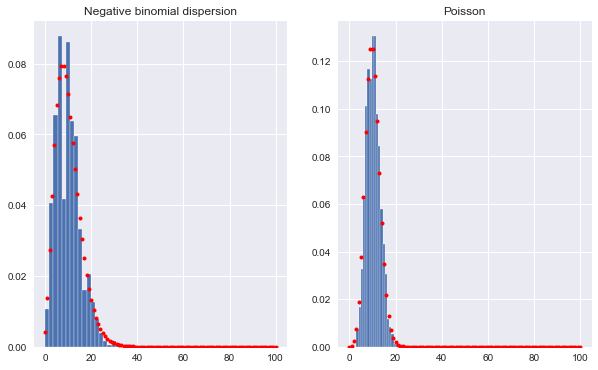

In [112]:
x=np.linspace(0, 100, 101)
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

ax1=axes[0]
ax1.hist(nbin_disp,edgecolor='white',density=True,bins=20)
ax1.plot(x, stats.nbinom.pmf(x, n=phi, p=(phi/(mu+phi))),  'ro', markersize=4)
ax1.set_title('Negative binomial dispersion')

ax2=axes[1]
ax2.hist(poisson_disp,edgecolor='white',density=True,bins=20)
ax2.plot(x, stats.poisson.pmf(x, mu), 'ro', markersize=4)
ax2.set_title('Poisson')

plt.show()

## Student-t distribution
For student-t distribution we will compare results for different number of samples. Basing on histograms we can sse that the bigger the degree of freedom is, the more values are distributed. 

In [113]:
#zad.3
# Student-t distribution degrees of freedom
with open('student_t_df.stan', 'r') as file:
    print(file.read())

data {
  real df;
  real mu;
  real sigma;
}

generated quantities {
    real y = student_t_rng(df, mu,sigma);
}


In [114]:
model_ppc=stan_utility.compile_model('student_t_df.stan')

Using cached StanModel


In [127]:
df = 1
mu = 0
sigma = 1
R_dict=[10, 20, 50, 100,200,500,1000]
df_list=[1,2,3,4,5,10]

y_dict = []
for i in range(0,len(R_dict)):
    for j in df_list:
        data_sim=dict(df=j, mu=mu,sigma=sigma)
        sim_dict=(model_ppc.sampling(data=data_sim,
                          algorithm="Fixed_param", 
                          iter=R_dict[i], 
                          warmup=0, 
                          chains=1,
                          seed=29042020))
        y_dict.append(sim_dict.extract()['y'])


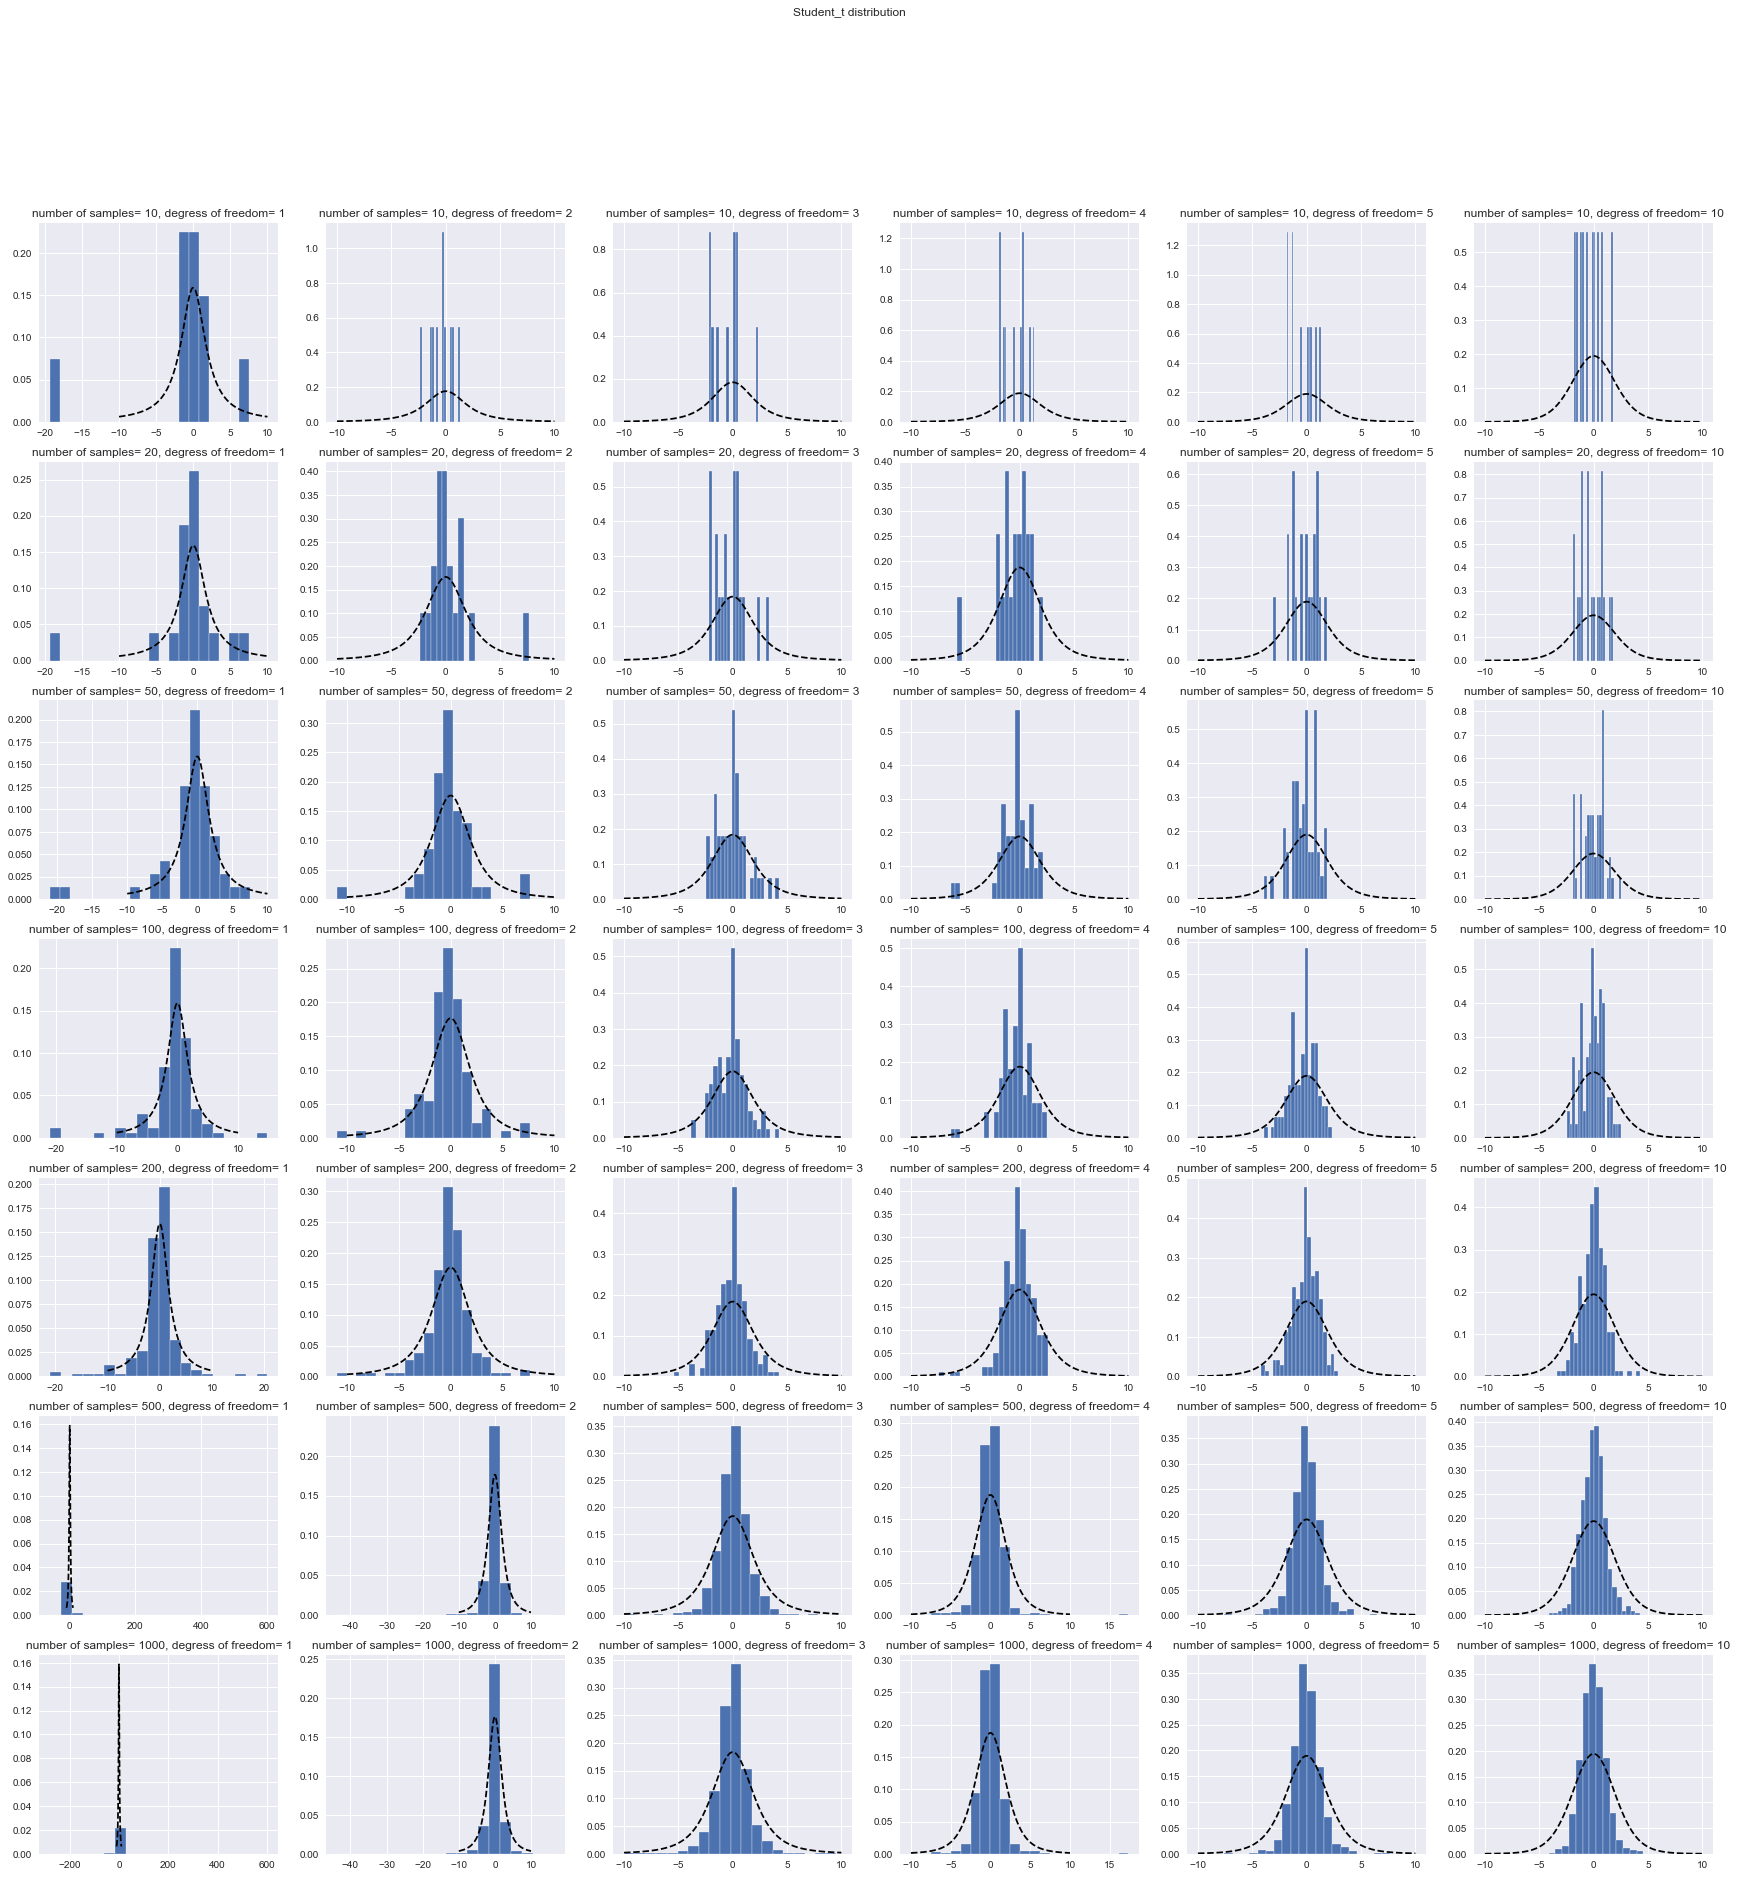

In [130]:
x=np.linspace(-10, 10 ,100)
fig, axes = plt.subplots(len(R_dict), len(df_list), figsize=(30,30))

fig.suptitle('Student_t distribution')
for i in range(0,len(R_dict)):
    for j in range(0,len(df_list)):
        ax=axes[i][j]
        ax.hist(y_dict[i*len(df_list)+j],bins=20,edgecolor='white',density=True)
        ax.plot(x,stats.t.pdf(x,df=df_list[j],loc=0,scale=2),color='black',linestyle='--')
        ax.set_title(r'number of samples= {}, degress of freedom= {}'.format(R_dict[i], df_list[j]))


plt.show()

## Mean and variance depending on number of samples
Mean goes up a little while raising number of samples. Variance falls down a little for bigger number of samples, but after that its raising firmly.

In [138]:
for i in range(0,len(R_dict)):
    print("for {} samples, {} degrees of freedom:".format(R_dict[i], df_list[0]))
    print("Mean = {}, variance = {}".format(np.mean(y_dict[i*len(df_list)]), np.var(y_dict[i*len(df_list)])))

for 10 samples, 1 degrees of freedom:
Mean = -1.2564286613958615, variance = 42.4835429314951
for 20 samples, 1 degrees of freedom:
Mean = -0.7089335465368032, variance = 25.538064681098398
for 50 samples, 1 degrees of freedom:
Mean = -1.1977899280479631, variance = 22.760911807367346
for 100 samples, 1 degrees of freedom:
Mean = -0.7274264304032754, variance = 17.927830063750918
for 200 samples, 1 degrees of freedom:
Mean = -0.47822442449838504, variance = 17.187124728337754
for 500 samples, 1 degrees of freedom:
Mean = 1.4203872069203756, variance = 790.008360056431
for 1000 samples, 1 degrees of freedom:
Mean = 0.6086611561520635, variance = 645.5957249332973


In [216]:
# zad.4
# Multivariate normal distribution
# 2D
with open('multi_normal_2d.stan', 'r') as file:
    print(file.read())

data {
  vector[2] mu;
  matrix[2,2] sigma;
}

generated quantities {
    vector[2] y = multi_normal_rng(mu,sigma);
}



In [217]:
model_ppc=stan_utility.compile_model('multi_normal_2d.stan')

Using cached StanModel


In [218]:
mu = [1, 2]
sigma = [[5, 2], [2, 3]]

In [219]:
from statsmodels.stats.moment_helpers import cov2corr 

In [220]:
corr= cov2corr(sigma)
corr

array([[1.        , 0.51639778],
       [0.51639778, 1.        ]])

In [221]:
R=1000
data_sim=dict(mu=mu,sigma=corr)
sim=model_ppc.sampling(data=data_sim,
                      algorithm="Fixed_param", 
                      iter=R, 
                      warmup=0, 
                      chains=1,
                      seed=29042020)

In [222]:
params=sim.extract()
y=params['y']
y1= [y[i][0] for i in range(0,R)]
y2= [y[i][1] for i in range(0,R)]

[]

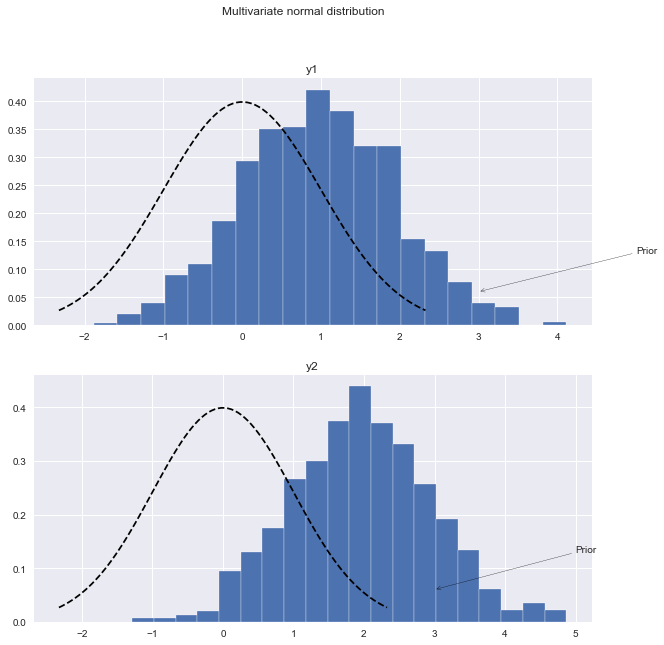

In [223]:
from scipy.stats import norm
x=np.linspace(norm.ppf(0.01), norm.ppf(0.99), 100)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))
fig.suptitle('Multivariate normal distribution')
ax0=axes[0]
ax0.hist(y1,bins=20,edgecolor='white',density=True)
ax0.plot(x,norm.pdf(x),color='black',linestyle='--')
ax0.annotate('Prior',xy=(3,0.06),xytext=(5,0.13),arrowprops={'arrowstyle':'->'})
ax0.set_title(r'y1')

ax1=axes[1]
ax1.hist(y2,bins=20,edgecolor='white',density=True)
ax1.plot(x,norm.pdf(x),color='black',linestyle='--')
ax1.annotate('Prior',xy=(3,0.06),xytext=(5,0.13),arrowprops={'arrowstyle':'->'})
ax1.set_title(r'y2')

plt.plot()

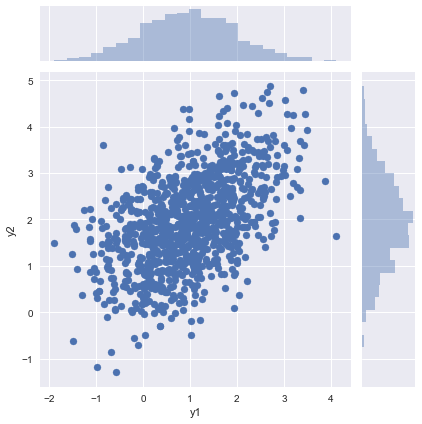

In [225]:
import seaborn as sns
df = pd.DataFrame(y, columns=["y1", "y2"])
sns.jointplot(x="y1", y="y2", data=df)

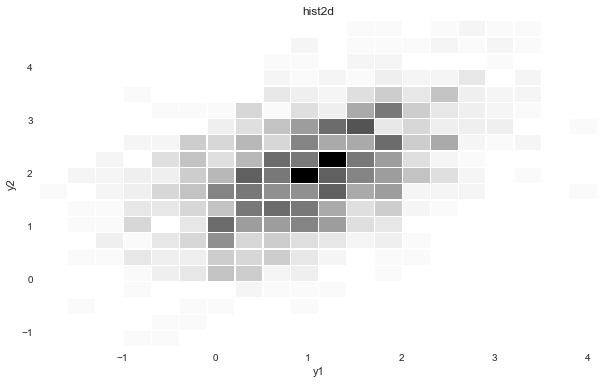

In [226]:
x=np.linspace(norm.ppf(0.01), norm.ppf(0.99), 100)

fig, axes = plt.subplots(1, 1, figsize=(10, 6))

axes.hist2d(y1,y2,bins=20,edgecolor='white', density=True)
axes.set_title(r'hist2d')
plt.xlabel('y1')
plt.ylabel('y2')

plt.show()

In [250]:
#3D
with open('multi_normal_3d.stan', 'r') as file:
    print(file.read())

data {
  vector[3] mu;
  matrix[3,3] sigma;
}

generated quantities {
    vector[3] y = multi_normal_rng(mu,sigma);
}



In [251]:
model_ppc=stan_utility.compile_model('multi_normal_3d.stan')

Using cached StanModel


In [268]:
mu = [1, 3, 7]
sigma = [[1, 0.2, 0.4], [0.2, 1, 0.5],[0.4, 0.5, 7]]

In [269]:
corr= cov2corr(sigma)
corr

array([[1.        , 0.2       , 0.15118579],
       [0.2       , 1.        , 0.18898224],
       [0.15118579, 0.18898224, 1.        ]])

In [270]:
R=1000
data_sim=dict(mu=mu,sigma=corr)
sim=model_ppc.sampling(data=data_sim,
                      algorithm="Fixed_param", 
                      iter=R, 
                      warmup=0, 
                      chains=1,
                      seed=29042020)


In [272]:
params=sim.extract()
y=params['y']
y1= [y[i][0] for i in range(0,R)]
y2= [y[i][1] for i in range(0,R)]
y3= [y[i][2] for i in range(0,R)]

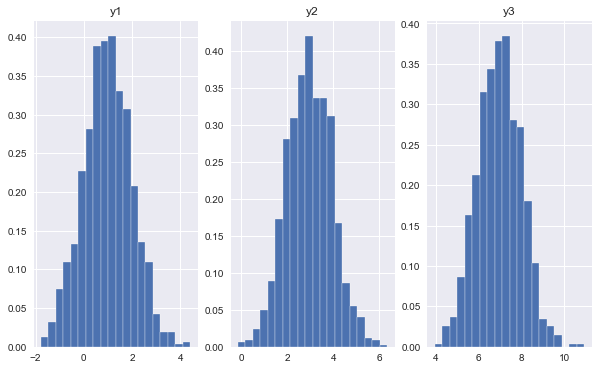

In [274]:
fig, axes = plt.subplots(1, 3, figsize=(10, 6))

ax1=axes[0]
ax1.hist(y1,bins=20,edgecolor='white',density=True)
ax1.set_title(r'y1')

ax2=axes[1]
ax2.hist(y2,bins=20,edgecolor='white',density=True)
ax2.set_title(r'y2')

ax2=axes[2]
ax2.hist(y3,bins=20,edgecolor='white',density=True)
ax2.set_title(r'y3')

plt.show()

In [275]:
#4D
with open('multi_normal_4d.stan', 'r') as file:
    print(file.read())

data {
  vector[4] mu;
  matrix[4,4] sigma;
}

generated quantities {
    vector[4] y = multi_normal_rng(mu,sigma);
}



In [276]:
model_ppc=stan_utility.compile_model('multi_normal_4d.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5b4fc3b47678a66b06d3d0776d83db05 NOW.


In [293]:
mu = [1, 3, 7, 4]
sigma = [[1, 0.1, 0.4, 0.2], [0.1, 1, 0.8, 0.5],[0.4, 0.8, 5, 0.1], [0.2, 0.5, 0.1, 2]]
#mu = [2, 8, 12, 4]
#sigma = [[1, 0.3, 0.5, 0.7], [0.3, 2, 0.8, 0.2],[0.5, 0.8, 12, 0.3], [0.7, 0.2, 0.3, 1]]

In [294]:
corr= cov2corr(sigma)
corr

array([[1.        , 0.1       , 0.17888544, 0.14142136],
       [0.1       , 1.        , 0.35777088, 0.35355339],
       [0.17888544, 0.35777088, 1.        , 0.03162278],
       [0.14142136, 0.35355339, 0.03162278, 1.        ]])

In [295]:
R=1000
data_sim=dict(mu=mu,sigma=corr)
sim=model_ppc.sampling(data=data_sim,
                      algorithm="Fixed_param", 
                      iter=R, 
                      warmup=0, 
                      chains=1,
                      seed=29042020)


In [299]:
params=sim.extract()
y=params['y']
y1= [y[i][0] for i in range(0,R)]
y2= [y[i][1] for i in range(0,R)]
y3= [y[i][2] for i in range(0,R)]
y4= [y[i][3] for i in range(0,R)]

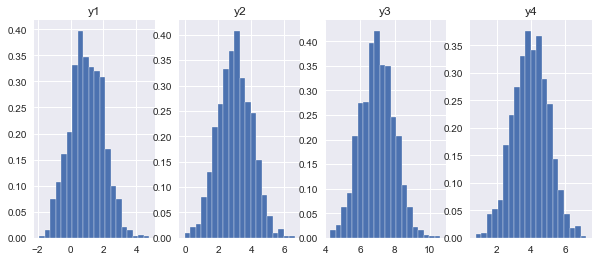

In [503]:
fig, axes = plt.subplots(1, 4, figsize=(10, 4))

ax1=axes[0]
ax1.hist(y1,bins=20,edgecolor='white',density=True)
ax1.set_title(r'y1')

ax2=axes[1]
ax2.hist(y2,bins=20,edgecolor='white',density=True)
ax2.set_title(r'y2')

ax3=axes[2]
ax3.hist(y3,bins=20,edgecolor='white',density=True)
ax3.set_title(r'y3')

ax4=axes[3]
ax4.hist(y4,bins=20,edgecolor='white',density=True)
ax4.set_title(r'y4')

plt.show()